In [1]:
%%HTML
<style>
	@import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

	body {
		font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
		line-height: 1.67;
	}
</style>

# Dynamic Periodic ETC for LPV Models under Saturation

_**[Event-based Control](https://github.com/andel-vitorio/event-based-control.git)**_

_by Andevaldo da Encarnação Vitório ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br)), last updated: April 20, 2025_

<!-- This notebook presents the implementation of the mathematical modeling and controller for a DC microgrid, represented by a buck converter with a CPL (Constant Power Load). The buck converter is a power conversion device that steps down a high DC voltage to a lower one. The CPL is a load that demands constant power regardless of variations in input voltage.

For the implementation, Python libraries such as Control, NumPy, and Matplotlib will be used. During implementation, the nonlinear system, shifted nonlinear system, and linearized system, all derived from the mathematical modeling, will be explored. -->

<!-- Detailed mathematical modeling can be found in the separate document titled ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), located in the `docs` directory.  -->

## 1. Importing Libraries

In [2]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os
import json
import random

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


## 2. LPV Model

In [3]:
def get_A(params):
  OP = params['op']

  A11 = - (params['rL'] / params['L'])
  A12 = - (1. / params['L'])
  A21 = 1. / params['C']
  A22 = (1. / params['C']) * (OP['Pcpl'] /
                              (OP['vC'] ** 2) - 1. / params['rC'])

  # A11 = 0
  # A12 = 1
  # A21 = 0
  # A22 = -0.1

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(params):
  B11 = params['Vin'] / params['L']
  B21 = 0.

  # B11 = 0.0
  # B21 = 0.1
  B = np.array([[B11],
                [B21]])
  return B


def plant_update(time, states, inputs, params):
  A = get_A(params)
  B = get_B(params)

  x = states.reshape(-1, 1)
  u = inputs[0:1].reshape(-1, 1)

  x_dot = A @ x + B @ u

  return x_dot


plant = ct.nlsys(plant_update, None, name="plant",
                 inputs=('u'), outputs=('x1', 'x2'),
                 states=('x1', 'x2'))

print(plant)

<NonlinearIOSystem>: plant
Inputs (1): ['u']
Outputs (2): ['x1', 'x2']
States (2): ['x1', 'x2']

Update: <function plant_update at 0x71bce7764fe0>
Output: None


## Predefinição da Simulação

In [4]:
def create_params(V_IN, RL, RC, L, C, PCPL_OP, VC_OP):
  """
  Create a dictionary of parameters for the system model.

  Parameters:
                  V_IN (float): Input voltage.
                  RL (float): Resistance of the inductor.
                  RC (float): Resistance of the capacitor.
                  L (float): Inductance.
                  C (float): Capacitance.
                  PCPL_OP (float): Operating power of the CPL.
                  VC_OP (float): Operating voltage of the capacitor.

  Returns:
                  dict: Dictionary of system parameters.

  """
  # Calculate the operating point (OP) values for inductor current and duty cycle
  IL_OP = (VC_OP / RC) + PCPL_OP / VC_OP
  D_OP = (RL * IL_OP) / V_IN + VC_OP / V_IN

  # Create the dictionary of parameters
  params = {
      "Vin": V_IN,
      "rL": RL,
      "rC": RC,
      "L": L,
      "C": C,
      "op": {"Pcpl": PCPL_OP, "vC": VC_OP, "iL": IL_OP, "d": D_OP},
  }

  return params

In [5]:
simulation_step = 1e-6
simulation_time = .1
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# # Input for open-loop simulation
u = np.zeros((1, len(timepts)))

params = create_params(
    V_IN=15, RL=1., RC=6, L=1e-3,
    C=2.2e-3, PCPL_OP=15, VC_OP=5
)

u_bar = [min(1 - params['op']['d'], params['op']['d'])]

X0 = [-3.83, -5.]
params

{'Vin': 15,
 'rL': 1.0,
 'rC': 6,
 'L': 0.001,
 'C': 0.0022,
 'op': {'Pcpl': 15,
  'vC': 5,
  'iL': 3.8333333333333335,
  'd': 0.5888888888888889}}

## Simulação da Planta em Malha Aberta

In [6]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[u], X0=X0, params=params
)

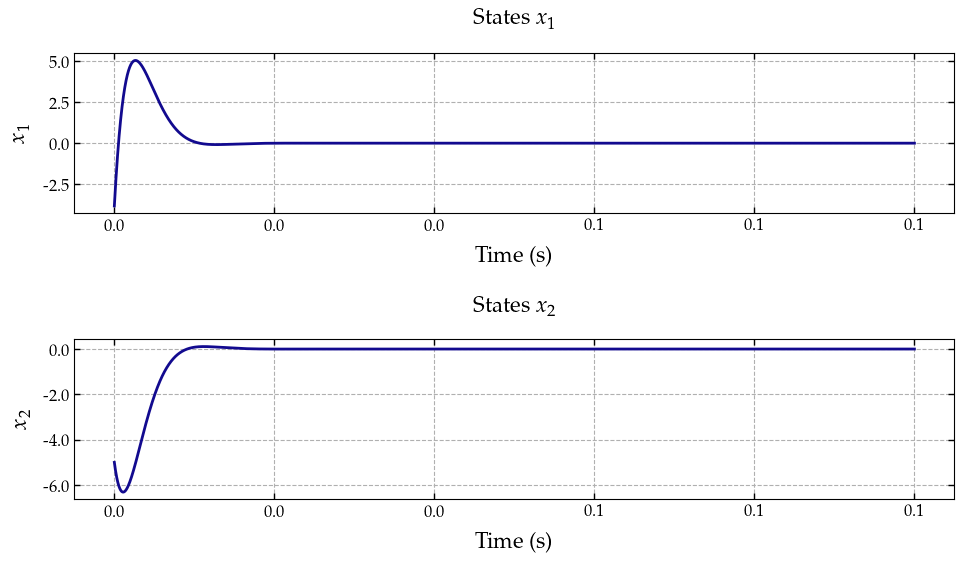

In [7]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
axs = fig.subplot_mosaic([["x1"], ["x2"]])

for i in [0, 1]:
  gph.plot(axs[f'x{i+1}'], t, y[i],
           xlabel='Time (s)', ylabel=f'$x_{i+1}$',
           title=f'States $x_{i+1}$',)
plt.tight_layout(pad=2.)

In [8]:
def He(M): return M + M.T


def get_parameter(h, λ, G1, G2, σx=1., σu=1., eps=1e-6):

  n_u = 1
  n_x = 2

  Onx = np.zeros((n_x, n_x))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  σux = σu * σx

  A = cp.Parameter((n_x, n_x), name=f'A', value=get_A(params))
  B = cp.Parameter((n_x, n_u), name=f'B', value=get_B(params))
  G1 = cp.Parameter((n_x, n_x), name=f'B', value=G1)
  G2 = cp.Parameter((n_u, n_u), name=f'B', value=G2)

  e = {}
  _es = np.eye(n_x)
  _ef = np.zeros((n_x, 6 * n_x))
  e[1] = np.block([[_es, _ef, np.zeros((n_x, n_x + n_u))]])
  e[7] = np.block([[_ef, _es, np.zeros((n_x, n_x + n_u))]])

  for i in range(2, 7):
    e[i] = np.block([[np.zeros((n_x, n_x * (i - 1))),
                      np.eye(n_x),
                      np.zeros((n_x, n_x * (7 - i))),
                      np.zeros((n_x, n_x + n_u))]])

  e[8] = np.block([[np.zeros((n_x,  7 * n_x)), np.eye(n_x),
                    np.zeros((n_x, n_u))]])

  e[9] = np.block([[np.zeros((n_u,  7 * n_x + n_x)), np.eye(n_u)]])

  for i in range(1, 10):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Stil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((n_x, n_x))

  Pcal = cp.bmat([[Ptil,   Mtil],
                  [Mtil.T, Stil]])

  constraints = []

  Ktil = cp.Variable((n_u, n_x), name=f'K')

  Qtil = cp.Variable((n_x, n_x), PSD=True)
  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)

  # constraints += [Qtil >= eps * np.eye(Qtil.shape[0])]
  # constraints += [Rtil >= eps * np.eye(Rtil.shape[0])]
  # constraints += [Ξtil >= eps * np.eye(Ξtil.shape[0])]
  # constraints += [Ψtil >= eps * np.eye(Ψtil.shape[0])]

  X = cp.Variable((n_x, n_x))
  Y1til = cp.Variable((2 * n_x, 2 * n_x))
  Y2til = cp.Variable((2 * n_x, 2 * n_x))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + λ * e[2].T + λ * e[3].T

  Π = cp.bmat([[e[1] - e[3]],
              [e[1] + e[3] - 2 * e[5]],
              [e[3] - e[4]],
              [e[3] + e[4] - 2 * e[6]]])

  κ1 = {}
  κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
  κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

  κ2 = cp.bmat([[e[2]], [e[1] - e[4]]])

  def get_Λ():
    Bscr = A @ X @ e[1] - X @ e[2] + σux * B @ Ktil @ e[3] + σux * \
        B @ Ktil @ e[7] + (σu - σux) * B @ Ktil @ e[8] + (1. - σu) * B @ e[9]

    Θtil = {}
    Θtil['0'] = 2 * κ1['0'].T @ Pcal @ κ2 + e[1].T @ Qtil @ e[1] - \
        e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + \
        He(Fscr @ Bscr) + e[8].T @ (np.eye(n_x) -
                                    X - X.T) @ e[8] - e[9].T @ e[9]

    Θtil['h'] = 2 * κ1['h'].T @ Pcal @ κ2 + e[1].T @ Qtil @ e[1] - \
        e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + \
        He(Fscr @ Bscr) + e[8].T @ (np.eye(n_x) -
                                    X - X.T) @ e[8] - e[9].T @ e[9]

    Φtil = {}

    Φtil1 = cp.bmat([[Rcal, O2nx],
                    [O2nx, Rcal]])
    Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, O2nx]])
    Φtil3 = cp.bmat([[O2nx, Y1til], [Y1til.T, Rcal]])

    Φtil['0'] = Φtil1 + Φtil2
    Φtil['h'] = Φtil1 + Φtil3

    Γ1_11 = Θtil['0'] - Π.T @ Φtil['0'] @ Π
    Γ1_12 = Π.T @ cp.bmat([[Y1til], [O2nx]])
    Γ1_13 = e[3].T @ X.T
    Γ1_14 = (σx * (e[3] + e[7]).T + (1. - σx) * e[8].T) @ Ktil.T @ G2.T
    Γ1_15 = (e[3] + e[7]).T @ X.T @ G1.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Rcal
    Γ1_23 = np.zeros((2 * n_x, n_x))
    Γ1_24 = np.zeros((Γ1_23.shape[0], Γ1_14.shape[1]))
    Γ1_25 = np.zeros((Γ1_23.shape[0], Γ1_15.shape[1]))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - Ψtil
    Γ1_34 = np.zeros((Γ1_33.shape[0], Γ1_14.shape[1]))
    Γ1_35 = np.zeros((Γ1_33.shape[0], Γ1_15.shape[1]))

    Γ1_41 = Γ1_14.T
    Γ1_42 = Γ1_24.T
    Γ1_43 = Γ1_34.T
    Γ1_44 = - np.eye(Γ1_14.shape[1])
    Γ1_45 = np.zeros((Γ1_43.shape[0], Γ1_15.shape[1]))

    Γ1_51 = Γ1_15.T
    Γ1_52 = Γ1_25.T
    Γ1_53 = Γ1_35.T
    Γ1_54 = np.zeros((Γ1_53.shape[0], Γ1_14.shape[1]))
    Γ1_55 = - np.eye(Γ1_15.shape[1])

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13, Γ1_14, Γ1_15],
                  [Γ1_21, Γ1_22, Γ1_23, Γ1_24, Γ1_25],
                  [Γ1_31, Γ1_32, Γ1_33, Γ1_34, Γ1_35],
                  [Γ1_41, Γ1_42, Γ1_43, Γ1_44, Γ1_45],
                  [Γ1_51, Γ1_52, Γ1_53, Γ1_54, Γ1_55],])

    Γ2_11 = Θtil['h'] - Π.T @ Φtil['h'] @ Π
    Γ2_12 = Π.T @ cp.bmat([[O2nx], [Y2til.T]])
    Γ2_13 = e[3].T @ X.T
    Γ2_14 = (σx * (e[3] + e[7]).T + (1. - σx) * e[8].T) @ Ktil.T @ G2.T
    Γ2_15 = (e[3] + e[7]).T @ X.T @ G1.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))
    Γ2_24 = np.zeros((Γ2_23.shape[0], Γ2_14.shape[1]))
    Γ2_25 = np.zeros((Γ2_23.shape[0], Γ2_15.shape[1]))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil
    Γ2_34 = np.zeros((Γ2_33.shape[0], Γ2_14.shape[1]))
    Γ2_35 = np.zeros((Γ2_33.shape[0], Γ2_15.shape[1]))

    Γ2_41 = Γ2_14.T
    Γ2_42 = Γ2_24.T
    Γ2_43 = Γ2_34.T
    Γ2_44 = - np.eye(Γ2_14.shape[1])
    Γ2_45 = np.zeros((Γ2_43.shape[0], Γ2_15.shape[1]))

    Γ2_51 = Γ2_15.T
    Γ2_52 = Γ2_25.T
    Γ2_53 = Γ2_35.T
    Γ2_54 = np.zeros((Γ2_53.shape[0], Γ2_14.shape[1]))
    Γ2_55 = - np.eye(Γ2_15.shape[1])

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13, Γ2_14, Γ2_15],
                  [Γ2_21, Γ2_22, Γ2_23, Γ2_24, Γ2_25],
                  [Γ2_31, Γ2_32, Γ2_33, Γ2_34, Γ2_35],
                  [Γ2_41, Γ2_42, Γ2_43, Γ2_44, Γ2_45],
                  [Γ2_51, Γ2_52, Γ2_53, Γ2_54, Γ2_55],])

    return Γ1, Γ2

  Λ = {}
  Λ['0'], Λ['h'] = get_Λ()

  constraints += [Λ['0'] << -eps * np.eye(Λ['0'].shape[0])]
  constraints += [Λ['h'] << -eps * np.eye(Λ['h'].shape[0])]
  constraints += [Pcal >> eps * np.eye(Pcal.shape[0])]

  # constraints += [(h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T) << 0.]

  # constraints += [X << 9e6 * np.eye(X.shape[0])]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil))
  # obj = cp.Minimize(0.)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True, eps=1e-8)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    # matrix_utils.show_matrix(Xinv.T @ Ξtil.value)
    # matrix_utils.show_matrix(X.value, 'X')

    P = Xinv.T @ Ptil.value @ Xinv
    M = Xinv.T @ Mtil.value @ Xinv
    S = Xinv.T @ Stil.value @ Xinv
    Q = Xinv.T @ Qtil.value @ Xinv
    R = Xinv.T @ Rtil.value @ Xinv

    Pcal_ = np.block([[P, M], [M.T, S]])

    # matrix_utils.show_matrix(Ptil.value, 'Ptil')

    P_eig = np.linalg.eig(P)[0]
    S_eig = np.linalg.eig(S)[0]
    Pcal_eig = np.linalg.eig(Pcal_)[0]

    error = False

    for i in range(n_x):
      if P_eig[i] <= 0:
        # print("P não é definida positiva!")
        error = True
      if S_eig[i] <= 0:
        # print("S não é definida positiva!")
        error = True

    # print('Autovalores de Pcal: ', Pcal_eig)
    for eig in Pcal_eig:
      if eig <= 0:
        # print("Pcal não é definida positiva!")
        error = True

    if error == False:
      K = Ktil.value @ Xinv
      # L = Ltil.value @ Xinv

      print(X.value)

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ},
          'controller': {'K': K},
          'lyapunov': {'P': P, 'M': M, 'S': S, 'Q': Q, 'R': R},
          # 'bounds': {'β': β.value}
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [11]:
# G1 = np.array([[1.5e-2, 0.], [0, 2.0e-2]])
# G2 = np.array([[1e1]])

G1 = np.array([[2.5e-5, 0.], [0, 1e-1]])
G2 = np.array([[1e0]])


h = 1e-5
λ = 3e-8

# Caso N2
σx_bar = .85
σu_bar = .85

# σx_bar = .9
# σu_bar = .9


design_results = get_parameter(h, λ, G1, G2, σx_bar, σu_bar, eps=1e-12)

Ξ = None
Ψ = None
K = None
P = None
M = None
S = None
Q = None
R = None

if design_results is not None:
  Ξ = design_results['etm']['Ξ']
  Ψ = design_results['etm']['Ψ']
  K = design_results['controller']['K']
  # G = design_results['controller']['G']
  P = design_results['lyapunov']['P']
  M = design_results['lyapunov']['M']
  S = design_results['lyapunov']['S']
  Q = design_results['lyapunov']['Q']
  R = design_results['lyapunov']['R']
  # β = design_results['bounds']['β']

  print('Resultados:')
  display(Math(rf'f^\star =' + tex.dec2tex(design_results['optimal_value'])))
  # display(Math(rf'\beta =' + tex.dec2tex(β)))
  # display(Math(rf'x^\top(t) P x(t) \preceq' + tex.dec2tex(1. / β)))

  # display(Math(rf'P = ' + dp.mat2tex(P)))

  print('Matrizes de Acionamento:')
  display(Math(rf'\Xi = ' + tex.mat2tex(Ξ)))
  display(Math(rf'\Psi = ' + tex.mat2tex(Ψ)))

  print('Matrizes de Controle:')
  display(Math(rf'K = ' + tex.mat2tex(K)))
  # display(Math(rf'G_{i_tex}= ' + tex.mat2tex(G[i])))
else:
  print('Problema não é factível!')

[[ 4903.15872576 -1507.0224692 ]
 [-1509.97534309  2672.36515538]]
Resultados:


<IPython.core.display.Math object>

Matrizes de Acionamento:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes de Controle:


<IPython.core.display.Math object>

In [ ]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T, σx_, σu_):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [-1.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []
    self.last_printed_sampling_time = -1.
    self.σx_list = [0.]
    self.σu_list = [0.]

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.σx_ = σx_
    self.σu_ = σu_
    self.σx = 1.
    self.σu = 1.

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'x1', 'x2'],
        outputs=['n', 'x1', 'x2', 'σx', 'σu']
    )

  def etm_update(self, t, n, u, params):
    # Obtenção do último estado transmitido e o estado atual
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)

    # Verifica se ocorrerá um novo evento de transmissão
    new_event = False
    is_sampling_instant = False
    if t >= self.next_sampling_time:
      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = n[0] + self.θ * Tcal < 0
      is_sampling_instant = True

    # Obtenção do x(t - τ)
    xτ = self.last_sampled_states  # Para t != nh
    if is_sampling_instant:
      xτ = x.copy()                # Para t == nh

    # Verifica a atualização de x_hat e ε
    ε = x_hat - xτ
    if new_event == True or t == 0.:
      x_hat = x.copy()
      ε = np.zeros((2, 1))

    # Atualiza a variável dinâmica
    Tcal = xτ.T @ self.Ψ @ xτ - ε.T @ self.Ξ @ ε
    n_dot = - self.λ * n + Tcal

    return n_dot8o

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0
        self.last_printed_sampling_time = -1.

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.
      elif t < self.previous_time:
        assert 'Integração Retrógrada'

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)

    new_event = False

    if (t >= self.next_sampling_time):
      if (t != self.last_printed_sampling_time):
        # print(f'Sampling Time: {t:.3f}')
        self.last_printed_sampling_time = t

      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = (n[0] + self.θ * Tcal < 0.) or (t == 0.)
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      self.σx = random.choices([0, 1], weights=[1. - self.σx_, self.σx_])[0]
      self.σu = random.choices([0, 1], weights=[1. - self.σu_, self.σu_])[0]
      self.event_times.append(t)
      self.σx_list.append(self.σx)
      self.σu_list.append(self.σu)

      print(t, self.σx, self.σu)

    x_to_send = x if new_event else x_hat

    return np.concatenate((n, x_to_send.reshape(-1),
                           np.array([self.σx, self.σu])))

In [13]:
class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = [0., 0.]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2'],
        outputs=['x1_hat', 'x2_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat', 'σx', 'σu'],
        outputs=['u'],
    )

  def control_output(self, t, x, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    σx, σu = u[2:4]

    σux = σx * σu
    f = np.array([[np.cos(G1[0][0] * x_hat[0][0])],
                  [np.cos(G1[1][1] * x_hat[1][0])]])
    u_til = σx * self.K @ x_hat + (1. - σx) * self.K @ f

    g = np.cos(G2[0][0] * u_til)
    u = σux * self.K @ x_hat + (σu - σux) * self.K @ f + (1. - σu) * g
    return [u]

In [14]:
λ = 1
θ = (1. / λ) * (np.exp(λ * h) - 1.)
θ

1.0000050000069649e-05

In [15]:
# Nome do arquivo de experimento
experiment_name = "Results/4/Trajectories-N6.json"
λ = 1
# Define se as simulações devem ser forçadas mesmo se o arquivo já existir
force_simulation = True
simulations_amount = 1

# Estrutura para armazenar os resultados
results_clsim = {
    'trajectories': [],
    'inter-event-times': [],
    'σx': [],
    'σu': []
}

# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    results_clsim = json.load(f)
else:
  def get_trajectories(i):
    θ = (1. / λ) * (np.exp(λ * h) - 1.)

    etm = DynamicETM('etm', Ψ, Ξ, θ, λ, h, 1., 1.)
    zoh = ZeroOrderHold()
    controller = Controller(K)

    closed_loop = ct.interconnect(
        (plant, etm.system, zoh.system, controller.system),
        connections=[
            ['plant.u', 'controller.u'],

            ['etm.x1_hat', 'zoh.x1_hat'],
            ['etm.x2_hat', 'zoh.x2_hat'],

            ['etm.x1', 'plant.x1'],
            ['etm.x2', 'plant.x2'],

            ['zoh.x1', 'etm.x1'],
            ['zoh.x2', 'etm.x2'],

            ['controller.x1_hat', 'zoh.x1_hat'],
            ['controller.x2_hat', 'zoh.x2_hat'],
            ['controller.σx', 'etm.σx'],
            ['controller.σu', 'etm.σu'],
        ],
        name='closed-loop system',
        outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u',
                 'etm.σx', 'etm.σu'],
    )

    etm.event_times = [0.]

    _, trajectories = ct.input_output_response(
        sys=closed_loop, T=timepts,
        X0=[X0[0], X0[1], 0.],
        params=params,
        solve_ivp_method='RK45',
        solve_ivp_kwargs={'max_step': simulation_step,
                          'first_step': simulation_step,
                          'atol': 1e-2, 'rtol': 1e-2},
    )

    # etm.event_times = etm.event_times[1:]

    inter_event_times = np.diff(etm.event_times).tolist()

    return {'trajectories': trajectories.tolist(),
            'σx': etm.σx_list,
            'σu': etm.σu_list,
            'inter-event-times': inter_event_times, }

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['σx'].append(res['σx'])
    results_clsim['σu'].append(res['σu'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim, f, indent=4)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

0.005170000000000362 1 1
0.0067200000000005675 1 1
0.008010000000000567 1 1
0.009530199999999451 1 1
0.012400199999997343 1 1
0.014100199999996094 1 1
0.015550199999995028 1 1
0.016710199999996057 1 1
0.0218500000000012 1 1
0.02341000000000276 1 1
0.02472000000000407 1 1
0.02609000000000544 1 1
0.02910000000000845 1 1
0.03078000000001013 1 1
0.032220000000011566 1 1
0.033450000000012796 1 1
0.038410000000017756 1 1
0.040000000000019346 1 1
0.04130000000002065 1 1
0.04267000000002202 1 1
0.04578000000002513 1 1
0.04747000000002682 1 1
0.04891000000002826 1 1
0.05013000000002948 1 1
0.05501000000003436 1 1
0.05657000000003592 1 1
0.05783000000003718 1 1
0.05903000000003838 1 1
0.06259000000004193 1 1
0.0642600000000436 1 1
0.06563000000004497 1 1
0.06677000000004611 1 1
0.071660000000051 1 1
0.07322000000005256 1 1
0.07449000000005383 1 1
0.07573000000005507 1 1
0.07919000000005853 1 1
0.0808500000000602 1 1
0.0822500000000616 1 1
0.08344000000006278 1 1
0.0882600000000676 1 1
0.08980000

In [16]:
%matplotlib qt

fig, axs = plt.subplot_mosaic([['η'], ['sat'], ['x'], ['iet']], 
                              figsize=(6, 14))

trajectories = results_clsim['trajectories']
trajectories_index = 0

inter_event_times = results_clsim['inter-event-times'][trajectories_index]
event_times = np.cumsum(inter_event_times) if len(inter_event_times) > 0 else np.array([])

print("Initial States: ", trajectories[trajectories_index][2][0])
print("Number of Triggered Events: ", len(inter_event_times))

if len(inter_event_times) > 0:
    print("Minimum IET Obtained: ", min(inter_event_times))
    print("Maximum IET Obtained: ", max(inter_event_times))
    print("Average Time Between Events: ", np.mean(inter_event_times))
else:
    print("No events were triggered, so no inter-event time statistics available.")

    
plot_cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 10, 'y_digits': 0, 'x_digits': 2,
            'x_label_fontsize': 14,
            'y_label_fontsize': 14,
            'tick_fontsize': 14,},
  'limits': { 'x_min': 0.0, 'x_max': simulation_time }
}

# Plots principais
gph.plot(
    axs['η'], t, 
    [v * 1e5 for v in trajectories[trajectories_index][0]],
    xlabel='Time [s]', ylabel='$\\eta(t)\\,$ [$\\times 10^{-5}$]',
    title='ETM Dynamic Variable',
    plot_cfg=plot_cfg)

# Plot sinal de saída
gph.plot(
    axs['x'], t, np.array(trajectories[trajectories_index][2]),
    xlabel='Time [s]', ylabel=r'$x_2$ [V]',
    title='Output Signal - Capacitor Voltage',
    plot_cfg=plot_cfg)

plot_cfg1 = plot_cfg.copy()
plot_cfg1['axis']['y_digits'] = 1

gph.plot(
    axs['sat'], t, 
    [(v) * 1e3 for v in trajectories[trajectories_index][3]],
    xlabel='Time [s]', ylabel='$u \\;$ [$\\times 10^{-3}$]',
    title='Control Signal - Duty Cycle', plot_cfg=plot_cfg1)

# Processamento de ataques no controle
print(len(results_clsim['σu'][trajectories_index]))
σu = np.atleast_1d(results_clsim['σu'][trajectories_index][1:])
print(σu)
print(event_times)
σu_attacks = np.sum(σu == 0.0)
print('Inputs deception attacks amount:', σu_attacks)

if len(event_times) > 0:
    interval_starts = event_times[0:]
    interval_ends = event_times[1:]
    n_intervals = min(len(σu), len(interval_starts))
    for i in range(n_intervals):
        if σu[i] == 0.0:
            axs['sat'].axvspan(interval_starts[i], interval_ends[i], color='#ff9999')

# Processamento de ataques nos estados
σx = np.atleast_1d(results_clsim['σx'][trajectories_index][1:])
σx_attacks = np.sum(σx == 0.0)
print('States deception attacks amount:', σx_attacks)

if len(event_times) > 0:
    interval_starts = event_times[0:]
    interval_ends = np.concatenate((event_times[1:], [simulation_time]))
    n_intervals = min(len(σx), len(interval_starts))
    for i in range(n_intervals):
        if σx[i] == 0.0:
            axs['x'].axvspan(interval_starts[i], interval_ends[i], color='#ff9999')

# Plot dos IETs
if len(inter_event_times) > 0:
    stem_cfg = plot_cfg.copy()
    stem_cfg['axis']['y_digits'] = 0
    gph.stem(
         axs['iet'], event_times,
        [et * 1e3 for et in inter_event_times],
        stem_cfg=stem_cfg,
        xlabel='Time [s]', ylabel='$t_{k+1} - t_k$ [$ms$]',
        title='Inter-event Times')
else:
    axs['iet'].text(0.5, 0.5, 'No triggered events',
                    ha='center', va='center', fontsize=14,
                    transform=axs['iet'].transAxes)
    axs['iet'].set_title('Inter-event Times')
    axs['iet'].set_xlabel('Time [s]')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
    axs['iet'].set_xlim([0, simulation_time])
    axs['iet'].set_ylim([0, 1])  # valor simbólico
    axs['iet'].grid(False)

plt.tight_layout(pad=3.)

Initial States:  -5.0
Number of Triggered Events:  47
Minimum IET Obtained:  0.00113000000000113
Maximum IET Obtained:  0.005170000000000362
Average Time Between Events:  0.0021053191489378356
48
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[0.00517   0.00672   0.00801   0.0095302 0.0124002 0.0141002 0.0155502
 0.0167102 0.02185   0.02341   0.02472   0.02609   0.0291    0.03078
 0.03222   0.03345   0.03841   0.04      0.0413    0.04267   0.04578
 0.04747   0.04891   0.05013   0.05501   0.05657   0.05783   0.05903
 0.06259   0.06426   0.06563   0.06677   0.07166   0.07322   0.07449
 0.07573   0.07919   0.08085   0.08225   0.08344   0.08826   0.0898
 0.09108   0.09221   0.09595   0.09759   0.09895  ]
Inputs deception attacks amount: 0
States deception attacks amount: 0


In [17]:
# import concurrent.futures
# import numpy as np
# import control as ct
# import os
# import json
# import itertools
# import pandas as pd

# # Nome do arquivo de experimento
# experiment_name = "CLSim_ETMParameters_23fev2025_Exp1.json"

# # Definição dos parâmetros
# upsilon_values = [1e-2, 1e0, 1e2]
# theta_values = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# # Gerar combinações de upsilon e theta
# upsilon_theta_pairs = list(itertools.product(upsilon_values, theta_values))

# # Estrutura para armazenar os resultados
# results_clsim_etm = {
#     'upsilon_theta': [],
#     'inter-event-times': [],
#     'experiment_parameters': {
#         'upsilon_values': upsilon_values,
#         'theta_values': theta_values,
#         'upsilon_theta_pairs': upsilon_theta_pairs,
#     }
# }

# # Função para obter trajetórias


# def get_trajectories(args):
#   upsilon, theta = args
#   etm = DynamicETM('etm', Ψ, Ξ, theta, upsilon, h)
#   zoh = ZeroOrderHold()
#   controller = Controller(K)

#   closed_loop = ct.interconnect(
#       (plant, etm.system, zoh.system, controller.system),
#       connections=[
#           ['plant.u1', 'controller.u1'],

#           ['etm.x1_hat', 'zoh.x1_hat'],
#           ['etm.x2_hat', 'zoh.x2_hat'],